In [1]:
from data import Data
import os

import numpy as np
from datetime import datetime
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection  import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.optimize import curve_fit
from scipy.optimize import fsolve


%matplotlib inline

In [2]:
Data()

for file_name in os.listdir('.'):
    if file_name.endswith('.csv'):
        print(file_name)
        


CSV files successfully generated
canada_cases.csv
bc_cases.csv
Predicted_New_Recoveries.csv


# Examining Data - Canada Wide

We first examine Covid-19 data in all provinces of Canada

Reading the data from csv file, then formatting the date column in the file. Then we set the date as the index

In [319]:
d_parser = lambda x: datetime.strptime(x, '%Y-%m-%d')
canada_data = pd.read_csv('canada_cases.csv', parse_dates=['Date'], date_parser=d_parser)
canada_data.set_index('Date', inplace=True)

Number of days that Canada has been impacted by Covid 19 is the number of rows

In [320]:
canada_data.tail()

,Num_of_days,New_Cases,New_Death,New_Recoveries,Total_Cases,Total_Death,Total_Recoveries
Date,,,,,,,
2020-12-07,318,6551,104,9688,426761,12820,343838
2020-12-08,319,6211,94,5836,432972,12914,349674
2020-12-09,320,6356,125,5703,439328,13039,355377
2020-12-10,321,6710,128,5631,446038,13167,361008
2020-12-11,322,6699,121,6591,452737,13288,367599


Calculating the Active Cases then add it it to the data frame

In [321]:
# Active cases
active_cases = canada_data['Total_Cases'] - canada_data['Total_Recoveries'] - canada_data['Total_Death'] 
active_cases.tail()

Date
2020-12-07    70103
2020-12-08    70384
2020-12-09    70912
2020-12-10    71863
2020-12-11    71850
dtype: int64

In [322]:
canada_data.insert(3, 'Active_Cases', active_cases)

Data frame with column 'Active_Cases added

In [7]:
canada_data.tail()

,Num_of_days,New_Cases,New_Death,Active_Cases,New_Recoveries,Total_Cases,Total_Death,Total_Recoveries
Date,,,,,,,,
2020-12-07,318,6551,104,70103,9688,426761,12820,343838
2020-12-08,319,6211,94,70384,5836,432972,12914,349674
2020-12-09,320,6356,125,70912,5703,439328,13039,355377
2020-12-10,321,6710,128,71863,5631,446038,13167,361008
2020-12-11,322,6699,121,71850,6591,452737,13288,367599


In [8]:
current_active_rate = (canada_data.iloc[-1]['Active_Cases'] / canada_data.iloc[-1]['Total_Cases']) * 100
current_recovery_rate = (canada_data.iloc[-1]['Total_Recoveries'] / canada_data.iloc[-1]['Total_Cases']) * 100
current_death_rate = (canada_data.iloc[-1]['Total_Death'] / canada_data.iloc[-1]['Total_Cases']) * 100


print(f'Current Active Cases Rate: {np.format_float_positional(current_active_rate, precision=2)}%')
print(f'Current Recovery Rate: {np.format_float_positional(current_recovery_rate, precision=2)}%')
print(f'Current Death Rate: {np.format_float_positional(current_death_rate, precision=2)}%')



Current Active Cases Rate: 15.87%
Current Recovery Rate: 81.19%
Current Death Rate: 2.94%


<Figure size 576x396 with 0 Axes>

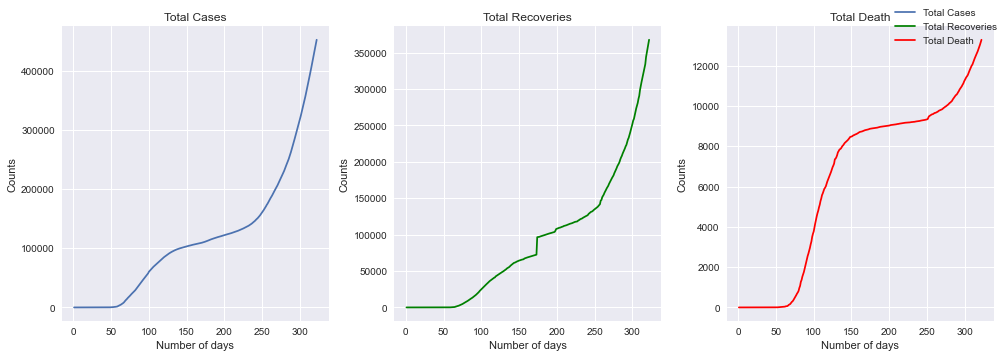

In [9]:
plt.style.use('seaborn')
fig = plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 5))

axes[0].plot(canada_data['Num_of_days'], canada_data['Total_Cases'], label='Total Cases')
axes[0].set_title('Total Cases')
axes[0].set_xlabel('Number of days')
axes[0].set_ylabel('Counts')

axes[1].plot(canada_data['Num_of_days'], canada_data['Total_Recoveries'], color='green', label='Total Recoveries')
axes[1].set_title('Total Recoveries')
axes[1].set_xlabel('Number of days')
axes[1].set_ylabel('Counts')

axes[2].plot(canada_data['Num_of_days'], canada_data['Total_Death'], color='red', label='Total Death')
axes[2].set_title('Total Death')
axes[2].set_xlabel('Number of days')
axes[2].set_ylabel('Counts')

fig.legend()

plt.tight_layout()


Finding the max the cases and death in different seasons

In [10]:
max_case_winter = canada_data['2020-01-25':'2020-03-01']['New_Cases'].max()
max_case_spring = canada_data['2020-03-01':'2020-06-22']['New_Cases'].max()
max_case_summer = canada_data['2020-06-22':'2020-09-22']['New_Cases'].max()
max_case_fall = canada_data['2020-09-22':'2020-12-10']['New_Cases'].max()

max_new_cases = canada_data['New_Cases'].max()
max_new_death = canada_data['New_Death'].max()

print(f'Max new cases in Winter 2020: {max_case_winter}')
print(f'Max new cases in Spring 2020: {max_case_spring}')
print(f'Max new cases in Summer 2020: {max_case_summer}')
print(f'Max new cases in Fall 2020: {max_case_fall}')


print(f'Max New Cases a day: {max_new_cases}')
print(f'Max New Death a day: {max_new_death}')

Max new cases in Winter 2020: 4
Max new cases in Spring 2020: 2602
Max new cases in Summer 2020: 1394
Max new cases in Fall 2020: 7003
Max New Cases a day: 7003
Max New Death a day: 228


Now, we take a look at the max value of new cases, active cases, new recoveries, and death in every week

In [323]:
max_week_new_cases = canada_data['New_Cases'].resample('W').max()
max_week_active_cases = canada_data['Active_Cases'].resample('W').max()
max_week_new_recoveries = canada_data['New_Recoveries'].resample('W').max()                                 
max_week_deaths = canada_data['New_Death'].resample('W').max()

It seems like our country has reached the peak of new cases in every week.

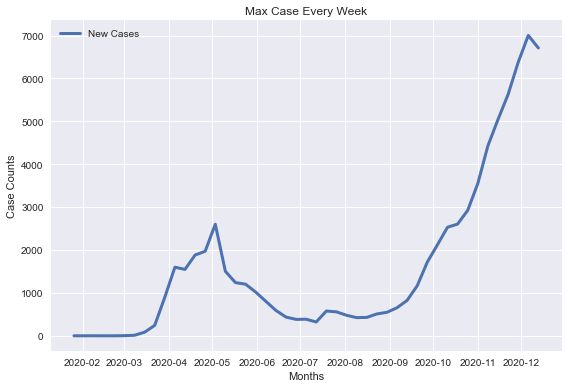

In [12]:
plt.style.use('seaborn')
plt.plot(max_week_new_cases, linewidth=3, label='New Cases')

plt.xlabel('Months')
plt.ylabel('Case Counts')
plt.title('Max Case Every Week')

plt.legend()


plt.tight_layout()

The active cases also reached the peaked while the number of new recoveries is increasing in every week.

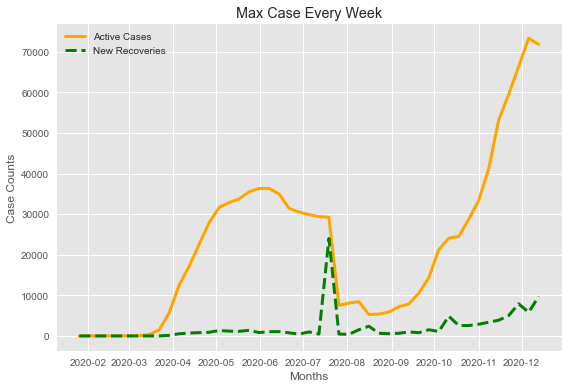

In [13]:
plt.style.use('ggplot')
plt.plot(max_week_active_cases, color='orange', linewidth=3, label='Active Cases')
plt.plot(max_week_new_recoveries, color='green', linewidth=3, linestyle='--', label='New Recoveries')

plt.xlabel('Months')
plt.ylabel('Case Counts')
plt.title('Max Case Every Week')

plt.legend()

plt.tight_layout()

In contrast, it seems like the death toll does not reach the peak yet, but it the current death count is way smaller than spring-summer time.

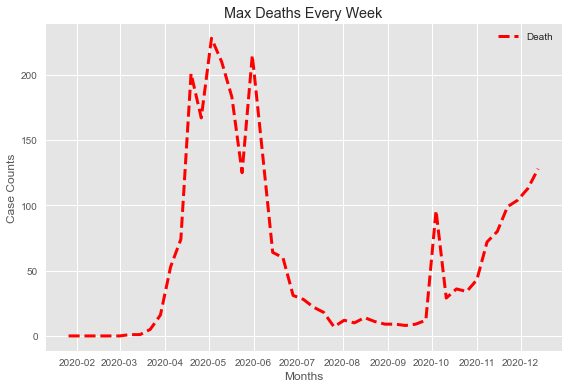

In [14]:
plt.plot(max_week_deaths, color='red', linewidth=3, linestyle='--', label='Death')

plt.xlabel('Months')
plt.ylabel('Case Counts')
plt.title('Max Deaths Every Week')

plt.legend()


plt.tight_layout()

As we can see, the Active Cases historam is right skewed.

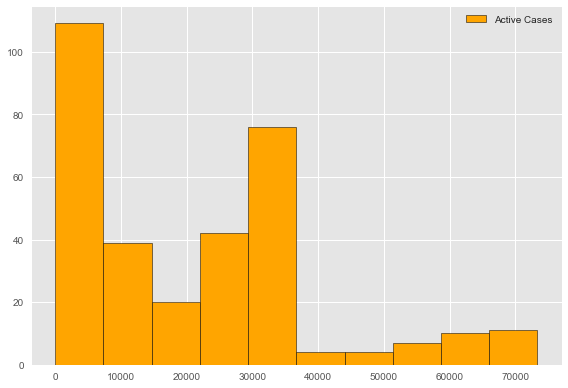

In [15]:
plt.style.use('ggplot')

plt.hist(active_cases, bins=10, color='orange', edgecolor='black', label="Active Cases")

plt.legend()


plt.tight_layout()



Some basic statistics about the data

In [16]:
canada_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Num_of_days,322.0,161.500000,93.097619,1.0,81.25,161.5,241.75,322.0
New_Cases,322.0,1406.055901,1685.366450,0.0,338.25,681.0,1726.50,7003.0
New_Death,322.0,41.267081,51.086300,0.0,5.00,16.5,67.00,228.0
Active_Cases,322.0,20962.900621,18594.588877,1.0,5315.25,19556.0,31979.75,73344.0
New_Recoveries,322.0,1141.611801,1943.799721,0.0,253.75,558.0,1062.75,23999.0
Total_Cases,322.0,117633.167702,105382.151729,1.0,28207.50,106961.5,148373.75,452737.0
Total_Death,322.0,6426.782609,4249.324161,0.0,993.00,8716.0,9274.25,13288.0
Total_Recoveries,322.0,90243.484472,88126.118504,0.0,8421.00,68836.5,128068.75,367599.0


Now, we look at all the plots between every variable in the data frame. We can see that there are some Linear Regression models in the graph. In this project, I am going to test if there are the correlation between the new cases, number of days and new recoveries. In other word, Can we predict how many new recoveries if there are new cases day by day?

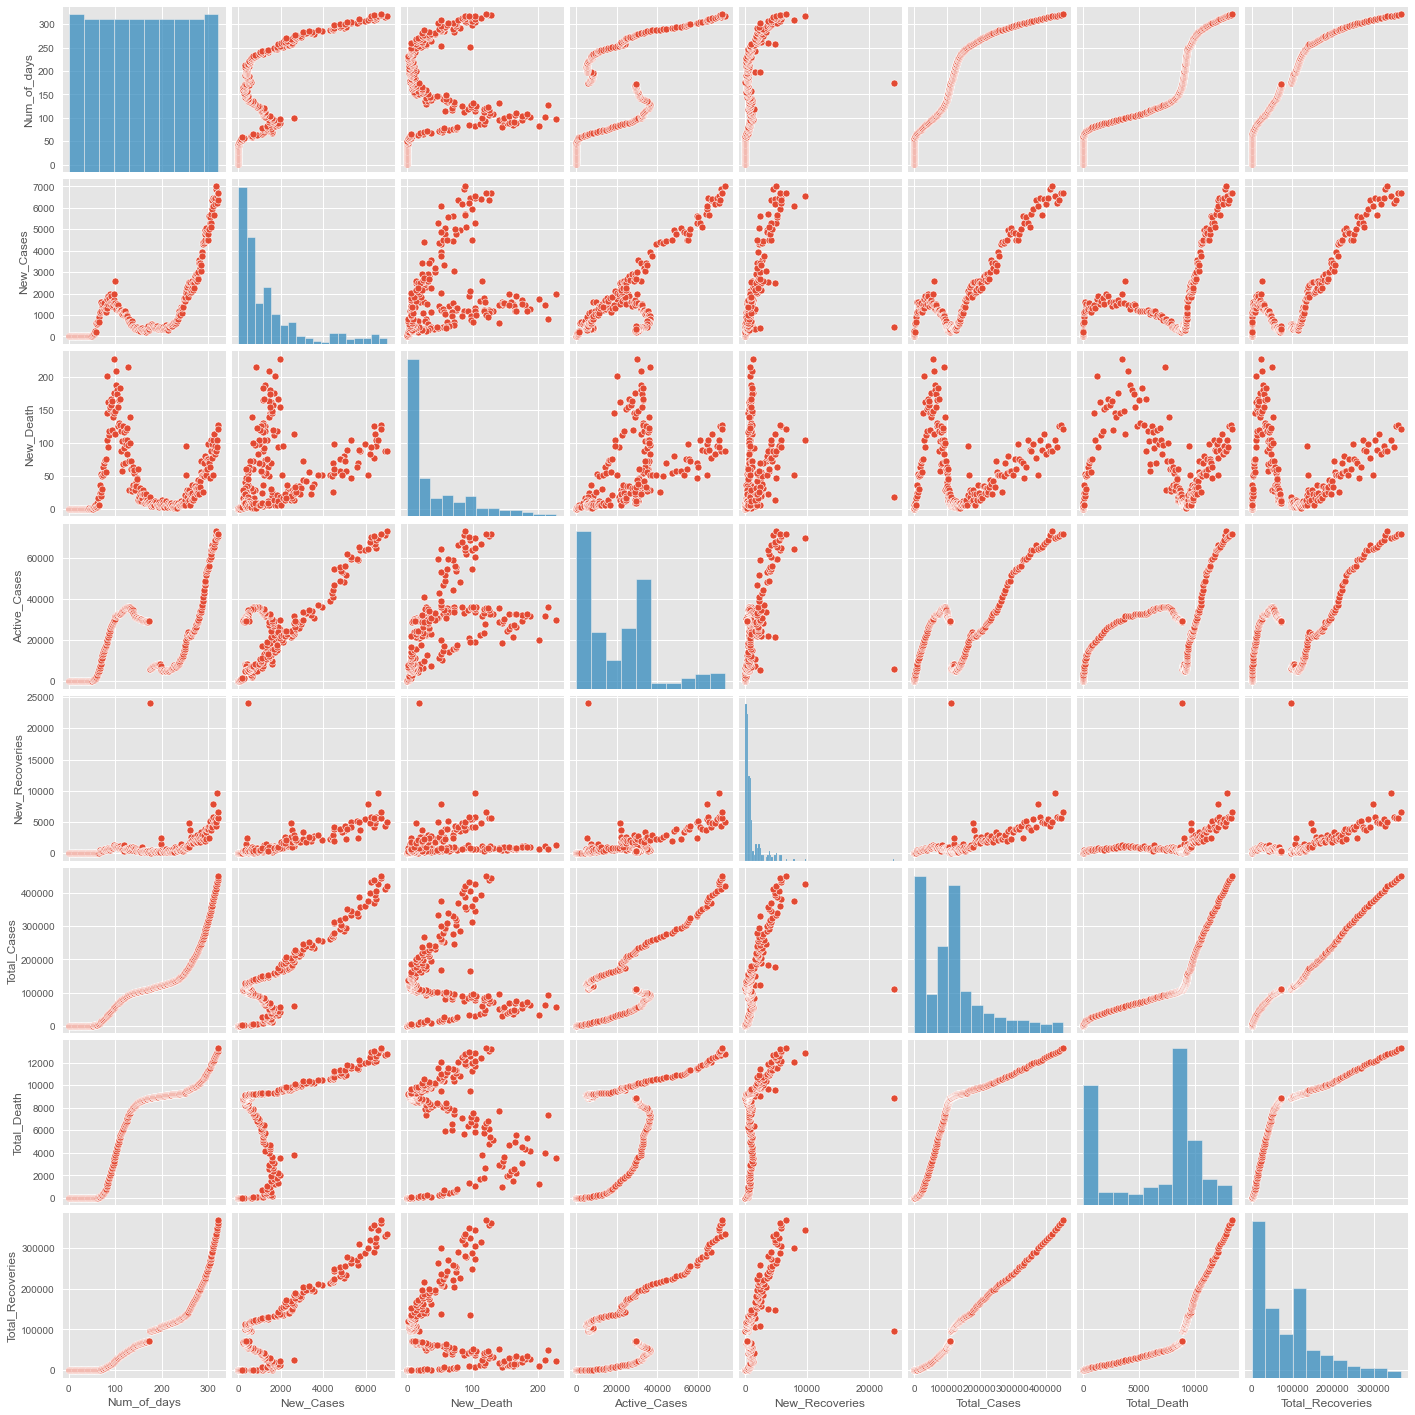

In [17]:
sns.pairplot(canada_data)

In [18]:
canada_data.columns

Index(['Num_of_days', 'New_Cases', 'New_Death', 'Active_Cases',
       'New_Recoveries', 'Total_Cases', 'Total_Death', 'Total_Recoveries'],
      dtype='object')

The independent variables are num_of_days and new_cases. The depedent variable is new_recoveries

In [19]:
X = canada_data[['Num_of_days', 'New_Cases']]
y = canada_data['New_Recoveries']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=110)

In [20]:
lm = LinearRegression()

In [21]:
lm.fit(X_train, y_train)

LinearRegression()

In [325]:
print(f'Intercept is {lm.intercept_}')

Intercept is -137.67125969114295


In [24]:
X_train.columns

Index(['Num_of_days', 'New_Cases'], dtype='object')

The coefficient between the independ variables and dependent variable 

In [25]:
pd.DataFrame(lm.coef_, X.columns, columns=['Coeff'])

,Coeff
Num_of_days,2.759650
New_Cases,0.615612


## Predictions

New recoveries are predicted and saved as the list

In [26]:
y_predictions = lm.predict(X_test)

We then export it into csv file for further record

In [275]:
d = {'Actual_New_Recoveries': y_test, 'Predicted_New_Recoveries': y_predictions}
df = pd.DataFrame(data=d)
df.to_csv('Canada_Predicted_New_Recoveries.csv', index=True)

Now we map the scatter plot between the predicted and actual variables. As you can see, the model seems to fit well.

Text(0.5, 1.0, 'Relationship between Actual and Predicted Recoveries')

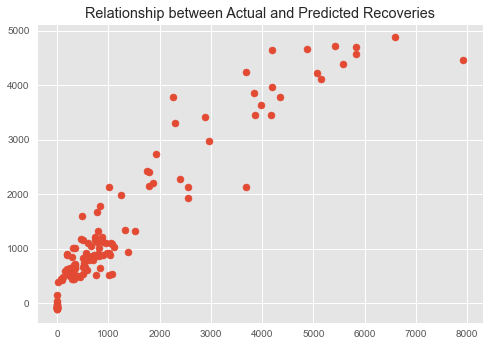

In [28]:
plt.scatter(y_test, y_predictions)
plt.title('Relationship between Actual and Predicted Recoveries')

The distribution of the residual (y_actual - y_predicted) variable is approximately Normal.

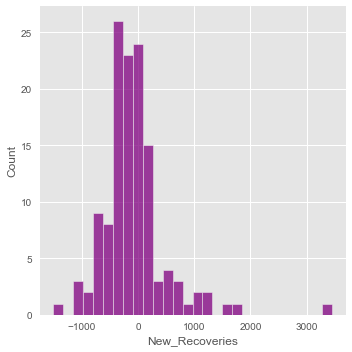

In [29]:
sns.displot((y_test - y_predictions), color='purple')

The r-square is around 87%. This number tells us that the regression model has been well fitted and strong.

In [30]:
print(f'r^2: {metrics.r2_score(y_test, y_predictions)}')
print(f'rmse: {np.sqrt(metrics.mean_squared_error(y_test, y_predictions))}')

r^2: 0.8714183122921071
rmse: 589.3070727970395


#  Examining Data - British Columbia Province

Now we examinie BC data. In this examination, We are looking for the peak new cases every day and predict the new cases

In [31]:
d_parser = lambda x: datetime.strptime(x, '%Y-%m-%d')
bc_data = pd.read_csv('bc_cases.csv', parse_dates=['Date'], date_parser=d_parser)
bc_data.set_index('Date', inplace=True)

In [32]:
bc_data.tail()

,Num_of_days,New_Cases,New_Death,New_Recoveries,Total_Cases,Total_Death,Total_Recoveries
Date,,,,,,,
2020-12-07,318,647,35,1629,38152,527,27287
2020-12-08,319,566,16,610,38718,543,27897
2020-12-09,320,619,16,551,39337,559,28448
2020-12-10,321,723,28,500,40060,587,28948
2020-12-11,322,737,11,650,40797,598,29598


In [141]:
x = bc_data['Num_of_days']
y = bc_data['New_Cases']

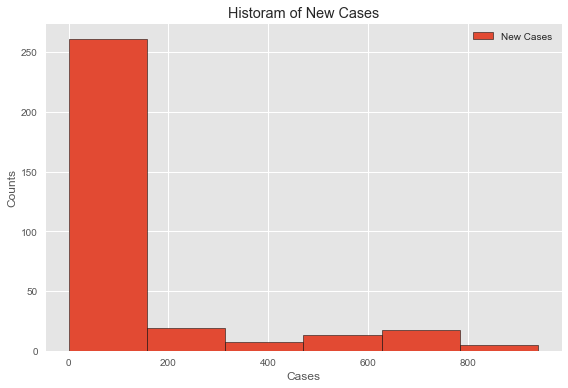

In [114]:
plt.hist(y, bins=6, label='New Cases', edgecolor='black')

plt.title('Historam of New Cases')
plt.xlabel('Cases')
plt.ylabel('Counts')

plt.legend()

plt.tight_layout()

The model is not linear and is curved. Therefore, I am going to use the Logistic Function to make the prediction.

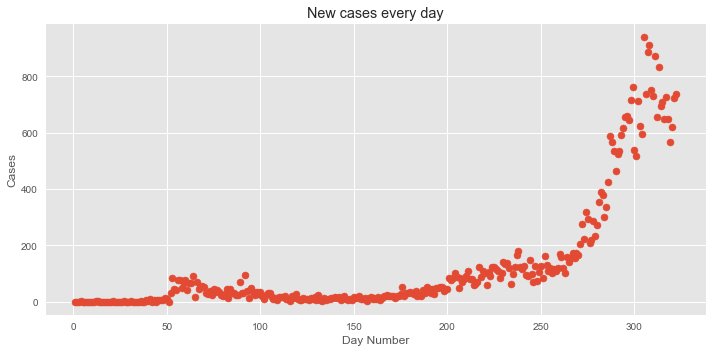

In [115]:
plt.figure(figsize=(10, 5))




plt.scatter(x, y)
plt.title('New cases every day')
plt.ylabel('Cases')
plt.xlabel('Day Number')

plt.tight_layout()

In [285]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))


The new case at peak is predicted to be at 922 cases

In [286]:
xlist = list(x)
ylist = list(y)
fit= curve_fit(logistic_model,xlist,ylist,p0=[12,500,50000])
fit[0][2]

922.0579800016596

With the margin of error 48. We can predict the predicted new case at peak is to be around 922 +- 48

In [287]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
errors[2]

48.73475560322326

## Predictions

In [311]:
y_pred_logi= [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in xlist]
rounded_y_pred_logi = [round(x) for x in y_pred_logi]

d = {'Actual_New_Cases': y, 'Predicted_New_Cases': rounded_y_pred_logi}
df = pd.DataFrame(data=d)
df.insert(0, 'Date', bc_data.index)



Comparing the predicted new cases and the actual new cases then export it to csv file for further record.

In [310]:
df.tail()

,Date,Actual_New_Cases,Predicted_New_Cases
317,2020-12-07,647,774
318,2020-12-08,566,781
319,2020-12-09,619,787
320,2020-12-10,723,793
321,2020-12-11,737,799


In [312]:
df.to_csv('BC_Predicted_New_Cases.csv', index=True)

As we can see, the scatter plot shows that the model seems to be fitted, but not well.

Text(0.5, 1.0, 'Relationship between Actual and Predicted New Cases')

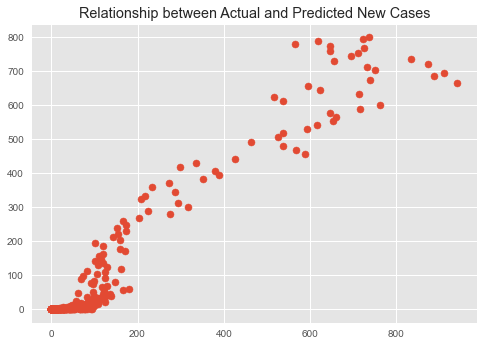

In [313]:
plt.scatter(y, rounded_y_pred_logi)
plt.title('Relationship between Actual and Predicted New Cases')

The Mean Square of Error

In [314]:
print(f'MSE: {metrics.mean_squared_error(y, y_pred_logi)}')

MSE: 3100.897912813761
